## Single & Complete Linkage Clustering
### Inhalt:
1. Generieren/Visualisierung von Beispieldaten (2D)
2. Helferfunktionen für Single-Linkage & Complete Linkage + Euclidian distance Algorithmus
3. Test bei klar getrennten Klassen
4. Test bei weniger klar getrennten Klassen

(NB: Aus Arbeitsgewohnheit wurden englische Funktionsnamen etc. verwendet, aber zumindest Kommentare wurden in Deutsch gehalten).

#### (0. Importe)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform 
# für effiziente distanz-matrix, ansonsten nichts aus scipy "geborgt"
import time
import copy 

#### 1. Daten für 2D-Klassen generieren

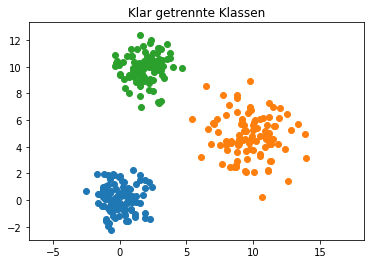

In [2]:
# Daten generieren
def multivariateGaussianCluster(numPoints=100, x_mean=0, y_mean=0, skew_x=1, skew_y=1):
    mean = [x_mean, y_mean]
    cov = [[skew_x, 0], [0, skew_y]]
    x_coords, y_coords = np.random.multivariate_normal(mean, cov, numPoints).T
    # (x,y) coords als liste von tuples:
    return zip(x_coords, y_coords)

# seed für kontrollierbare zufallsergebnisse:
np.random.seed(0)
C1 = multivariateGaussianCluster(numPoints=100)
C2 = multivariateGaussianCluster(numPoints=100, x_mean=10, y_mean=5, skew_x=3, skew_y=3)
C3 = multivariateGaussianCluster(numPoints=100, x_mean=2, y_mean=10, skew_x=1, skew_y=1)
Ctotal = C1 + C2 + C3
for c in (C1, C2, C3):
    plt.scatter(*zip(*c))
plt.axis('equal')
plt.title("Klar getrennte Klassen")
plt.show()

#### 2. Funktionen für Clustering-Algorithmus

In [3]:
def distanceMatrix(points):
    """Deklaration von nicht-redundanter euklidischer Distanzmatrix für Punktemenge"""
    # Verwende scipy-Implementation der Distanzmatrix
    # Eigene Implentation (z.B. mit x/y-for-loops) natürlich auch möglich
    dM = squareform(pdist(points))
    # Maskiere oberes 'Dreieck' mit NaNs für eindeutigeres indexing
    np.fill_diagonal(dM, np.nan)
    il1 = np.triu_indices(dM.shape[0])
    dM[il1] = np.nan
    return dM

def unflattenIndex(flat_index, matrix):
    """Helferfunktion: Index von 1D Matrix in 2D Matrix umwandeln"""
    indX,indY = np.unravel_index(flat_index, matrix.shape)
    return (indX, indY)

def getMinDistance(dM):
    """Minimum- bzw. Maximum-Koordinate der Distanzmatrix für Single oder Total Linkage finden"""
    # np.nanargmin() überspringt NaNs
    minLink = np.nanargmin(dM)
    if minLink.size == 1:
        (i,j) = unflattenIndex(minLink, dM)
    else: 
        # falls mehrere idente minima bestehen
        (i,j) = unflattenIndex(minLink, dM)[0]
    return i,j

def mergeClassDistances(i,j,dM, linkage_type="complete"):
    """Update der Distanzmatrix anhand Minimum-Koordinaten"""
    if linkage_type=="single":
        # Vergleiche rows, update Werte mit relativen MINIMUM-Werts:
        dM[i,:][dM[i,:]>dM[j,:]]=dM[j,:][dM[i,:]>dM[j,:]]
        # Vergleiche columns, update Werte mit relativem MINIMUM-Wert:
        dM[:,i][dM[:,i]>dM[:,j]]=dM[:,j][dM[:,i]>dM[:,j]]
    elif linkage_type=="complete":
        # Vergleiche rows, update Werte mit relativem MAXIMUM-Wert:
        dM[i,:][dM[i,:]<dM[j,:]]=dM[j,:][dM[i,:]<dM[j,:]]
        # Vergleiche columns, update Werte mit relativem MAXIMUM-Wert:
        dM[:,i][dM[:,i]<dM[:,j]]=dM[:,j][dM[:,i]<dM[:,j]]
    # i bleibt als merged class mit Minimum-Distance-Werten, j wird mit NaNs virtuell 'gelöscht':
    dM[j,:] = np.nan
    dM[:,j] = np.nan
    return dM

np.warnings.filterwarnings('ignore') #Ignoriere unwichtige Beschwerden über NaN Werte

In [4]:
def listInd(x, class_sets):
    for i in range(len(class_sets)):
        if x in class_sets[i]:
            return i

def mergeSets(x,y, class_sets):
    """merge 2 sets mit x and y in der 'class_sets' liste"""
    xind = listInd(x, class_sets)
    yind = listInd(y, class_sets)
    if xind == yind:
        raise ValueError("Sollte nicht passieren: Werte schon in gleicher Klasse")
    else:
        class_sets[xind] = set.union(class_sets[xind], class_sets[yind])
        del class_sets[yind]

def appendToSet(x,y, class_sets):
    """füge value y zu set mit x in 'class_sets' liste hinzu"""
    xind = listInd(x, class_sets)
    class_sets[xind].add(y)

def trackSets(x,y, class_sets):
    """updates list of clustering classes based on new value pairs"""
    # wenn das erste mal läuft, ist class_sets noch leer:
    if not class_sets:
        # Erster Eintrag, also braucht man kein indiziertes appendToSet
        class_sets.append(set([x,y]))
    else:
        all_vars = set.union(*class_sets[:])
        x_classed = (x in all_vars)
        y_classed = (y in all_vars)
        if x_classed and y_classed:
            # zwei sets (also klassen) mergen:
            mergeSets(x,y,class_sets) 
        elif x_classed and not y_classed:
            # neuen einzelwert y zu klasse x hinzufügen
            appendToSet(x, y, class_sets)
        elif y_classed and not x_classed:
            # neuen einzelwert x zu klasse y hinzufügen
            appendToSet(y, x, class_sets)
        else:
            # Neue Klasse erschaffen und einzelwerte als set hinzufügen
            class_sets.append(set([x,y]))


In [5]:
def runClustering(points, linkage):
    # loop-variable class_sets
    class_sets = []
    # allgemeiner cluster-tracker um "evolution" der class_sets widerzuspiegeln:
    overall_cluster_tracker = []
    # ----Algorithmus----
    # 0. anfangs die Distanzmatrix bestimmen
    dM = distanceMatrix(points)
    # 1. Danach Loop über Länge der Cluster-Menge:
    for counter in range(len(points)-1):
        # 1a. Koordinaten der Single Linkage Minimumdistanz in der Distanzmatrix bestimmen
        (i,j) = getMinDistance(dM)
        # 1b. Nächste Distanzmatrix-einträge mittels selektiver NaN-Einträge "mergen", aber nicht neuberechnen:
        mergeClassDistances(i,j,dM, linkage_type=linkage)
        # 1c. Klassenliste updaten 
        trackSets(i,j, class_sets)
        if class_sets:
            # tracke entwicklung der klassen für visualisierung 
            # (für kleinere - paar 1000 punkte - datasets möglich, ansonsten wahrscheinlich memory-probleme):
            overall_cluster_tracker.append(copy.copy(class_sets))
        else: 
            print "shouldn't see this msg..."
        # 2. terminiere wenn alle punkte in klassen und nur eine klasse übrig, ansonsten zurück zu 0.
        if len(set.union(*class_sets[:])) == len(points) and len(class_sets) ==1:
            # print "all points clustered"
            break
    return overall_cluster_tracker


####  3. Clustering von klar getrennten Klassen

#------- Visualisierung - Single Linkage -------


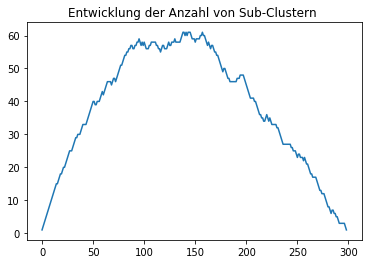

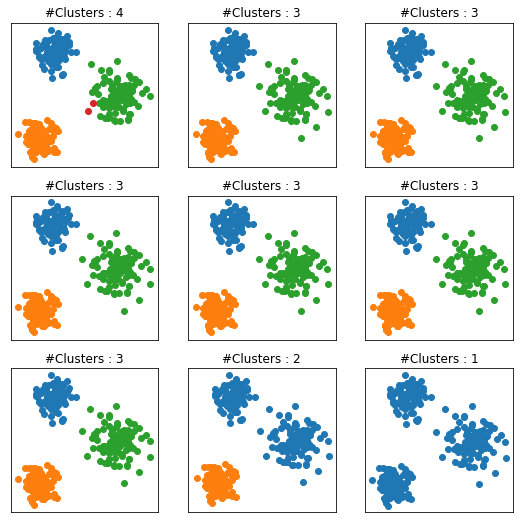

#------- Visualisierung - Complete Linkage -------


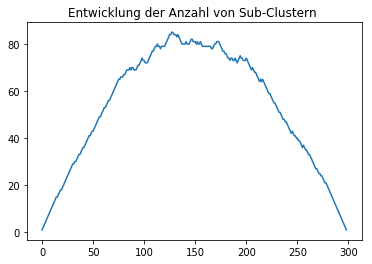

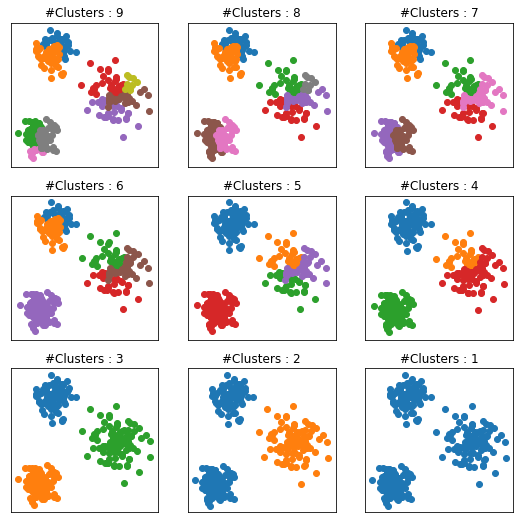

In [6]:
clear_clusters_single = runClustering(Ctotal, "single")
clear_clusters_complete = runClustering(Ctotal, "complete")

def genericVisualise(overall_cluster_tracker, original_points):
    ##### entwicklung der anzahl der clusterungen visualisieren:
    cluster_numbers = [len(c) for c in overall_cluster_tracker]
    plt.plot(range(len(cluster_numbers)), cluster_numbers)
    plt.title("Entwicklung der Anzahl von Sub-Clustern ")
    plt.show()

    # letzten 9 clustering-schritte visualisieren:
    fig, axes = plt.subplots(3,3, figsize=(9,9))
    for i, ax in enumerate(axes.flatten()):
        # (9-i) um richtige reihenfolge bei cluster-evolution zu erreichen:
        cluster_step = overall_cluster_tracker[-(9-i)]
        # ge-clusterte punkte einblenden:
        for k, cl in enumerate(cluster_step):
            clustered = [original_points[c] for c in cl]
            ax.scatter(*zip(*clustered))
        # paar kosmetische änderungen
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        ax.set_title("#Clusters : {}".format(len(cluster_step)))
    plt.show()

print "#------- Visualisierung - Single Linkage -------"
genericVisualise(clear_clusters_single, Ctotal)
print "#------- Visualisierung - Complete Linkage -------"
genericVisualise(clear_clusters_complete, Ctotal)

Bei klar getrennten Clustern scheint  der Single-Linkage Algorithmus etwas früher zu konvergieren (die letzten 9 Schritte bevor alle Punkte eingeteilt sind unterscheiden sich kaum im Mapping). Beide Algorithmen finden hier aber zu 'richtigen' Clustern (jeweils die beiden ersten subplot wo Clusteranzahl gleich 3 ist, sind ident).

NB: Wenn sich zwischen Schritt (n-3) und (n-6) bei Single Linkage die Cluster-Zahl **nicht** verändert bedeutet dies lediglich dass nicht-geclusterte Punkte zu bereits bestehenden Clustern hinzugefügt werden.

#### 4. Verhalten bei nicht klar getrennten Cluster (Beispiel):


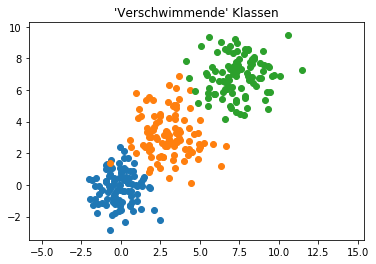

#------- Visualisierung - Single Linkage -------


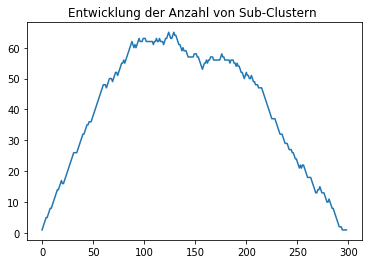

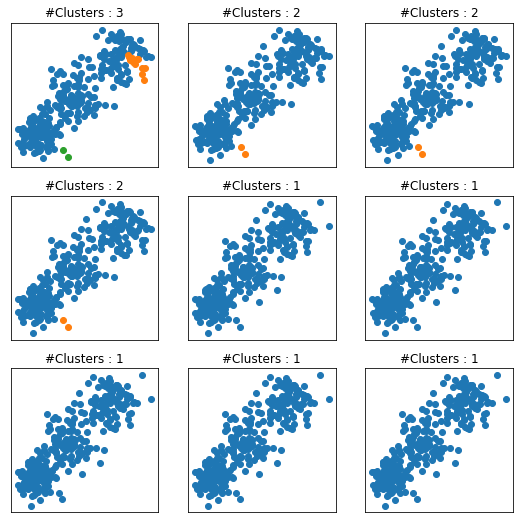

#------- Visualisierung - Complete Linkage -------


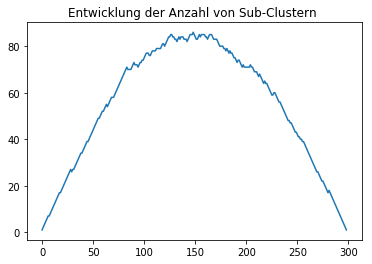

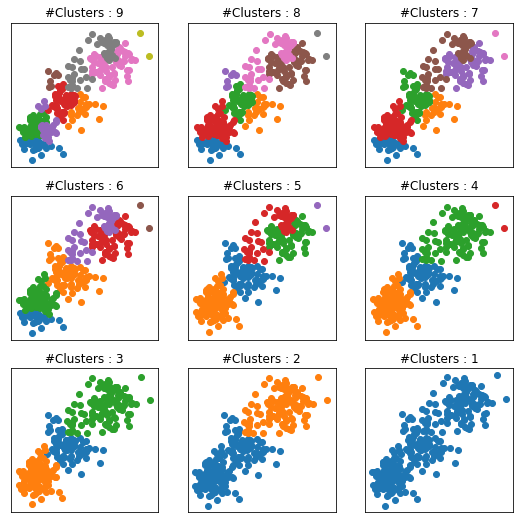

In [7]:
C4 = multivariateGaussianCluster(numPoints=100)
C5 = multivariateGaussianCluster(numPoints=100, x_mean=3, y_mean=3, skew_x=2, skew_y=2)
C6 = multivariateGaussianCluster(numPoints=100, x_mean=7, y_mean=7, skew_x=2, skew_y=2)
Ctotal_unclear = C4 + C5 + C6
for c in (C4, C5, C6):
    plt.scatter(*zip(*c))
plt.axis('equal')
plt.title("'Verschwimmende' Klassen")
plt.show()

unclear_clusters_single = runClustering(Ctotal_unclear, "single")
unclear_clusters_complete = runClustering(Ctotal_unclear, "complete")

print "#------- Visualisierung - Single Linkage -------"
genericVisualise(unclear_clusters_single, Ctotal_unclear)
print "#------- Visualisierung - Complete Linkage -------"
genericVisualise(unclear_clusters_complete, Ctotal_unclear)

Bei 'verschwommenen' Clustern scheint sich der Complete Linkage Algorithmus etwas leichter zu tun (um Zeitpunkt N(Cluster)=3 oder N(Cluster)=4 herum erscheinen sinnvolle Einteilungen, während der Single Linkage Algorithmus - auch bei Betrachtung von mehr als nur der letzten 9 Zeitschritte - eher der länglichen Sammelmenge "entlangzuwandern" scheint.